In [8]:
print("hello")

hello


In [9]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def load_and_preprocess_data(file_path):
    """
    Load and preprocess EEG data for neural network training
    """
    # Load data
    df = pd.read_csv(file_path)

    # Parse complex coefficients
    df['real_part'] = df['coeff'].apply(lambda x: complex(x).real)
    df['imag_part'] = df['coeff'].apply(lambda x: complex(x).imag)

    # Create feature matrix
    # Group by participant, trial, and frequency to get electrode readings
    feature_data = []
    labels = []

    for (participant, trial, frequency), group in df.groupby(['participant', 'trial', 'frequency']):
        # Create feature vector: [real_C3, imag_C3, real_C4, imag_C4, ...]
        feature_vector = []

        # Sort electrodes to ensure consistent ordering
        electrodes = sorted(group['electrode'].unique())

        for electrode in electrodes:
            electrode_data = group[group['electrode'] == electrode]
            if len(electrode_data) > 0:
                feature_vector.extend([
                    electrode_data['real_part'].iloc[0],
                    electrode_data['imag_part'].iloc[0]
                ])
            else:
                feature_vector.extend([0.0, 0.0])  # Fill missing electrodes

        feature_data.append(feature_vector)
        labels.append(group['condition'].iloc[0])

    # Convert to numpy arrays
    X = np.array(feature_data)
    y = np.array(labels)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Normalize features
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    return X_normalized, y_encoded, label_encoder, scaler

def create_data_loaders(X, y, test_size=0.2, batch_size=64):
    """
    Create train and test data loaders
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Create datasets
    train_dataset = EEGDataset(X_train, y_train)
    test_dataset = EEGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGClassifier(nn.Module):
    def __init__(self, input_size=64, hidden_size1=128, hidden_size2=64, num_classes=4):
        super(EEGClassifier, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # First hidden layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Second hidden layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output layer
        x = self.fc3(x)
        return x

    def predict_proba(self, x):
        """Get prediction probabilities"""
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = F.softmax(logits, dim=1)
        return probabilities

Loading and preprocessing data...
Starting training...
Starting training...


Training:  10%|█         | 10/100 [00:38<05:43,  3.82s/it]

Epoch [10/100]
Train Loss: 1.3869, Train Acc: 24.93%
Test Loss: 1.3865, Test Acc: 25.00%
--------------------------------------------------


Training:  20%|██        | 20/100 [01:17<05:25,  4.07s/it]

Epoch [20/100]
Train Loss: 1.3868, Train Acc: 24.80%
Test Loss: 1.3865, Test Acc: 25.00%
--------------------------------------------------


Training:  30%|███       | 30/100 [01:55<04:29,  3.85s/it]

Epoch [30/100]
Train Loss: 1.3870, Train Acc: 24.85%
Test Loss: 1.3870, Test Acc: 25.00%
--------------------------------------------------


Training:  40%|████      | 40/100 [02:31<03:33,  3.56s/it]

Epoch [40/100]
Train Loss: 1.3868, Train Acc: 24.89%
Test Loss: 1.3865, Test Acc: 25.00%
--------------------------------------------------


Training:  50%|█████     | 50/100 [03:06<02:58,  3.57s/it]

Epoch [50/100]
Train Loss: 1.3874, Train Acc: 24.80%
Test Loss: 1.3868, Test Acc: 25.00%
--------------------------------------------------


Training:  60%|██████    | 60/100 [03:46<02:43,  4.10s/it]

Epoch [60/100]
Train Loss: 1.3869, Train Acc: 24.93%
Test Loss: 1.3867, Test Acc: 25.00%
--------------------------------------------------


Training:  70%|███████   | 70/100 [04:32<02:18,  4.60s/it]

Epoch [70/100]
Train Loss: 1.3869, Train Acc: 25.04%
Test Loss: 1.3864, Test Acc: 25.00%
--------------------------------------------------


Training:  80%|████████  | 80/100 [05:13<01:18,  3.90s/it]

Epoch [80/100]
Train Loss: 1.3869, Train Acc: 25.00%
Test Loss: 1.3869, Test Acc: 25.00%
--------------------------------------------------


Training:  90%|█████████ | 90/100 [05:53<00:42,  4.24s/it]

Epoch [90/100]
Train Loss: 1.3869, Train Acc: 25.03%
Test Loss: 1.3866, Test Acc: 25.00%
--------------------------------------------------


Training: 100%|██████████| 100/100 [06:38<00:00,  3.98s/it]

Epoch [100/100]
Train Loss: 1.3867, Train Acc: 25.30%
Test Loss: 1.3867, Test Acc: 25.00%
--------------------------------------------------


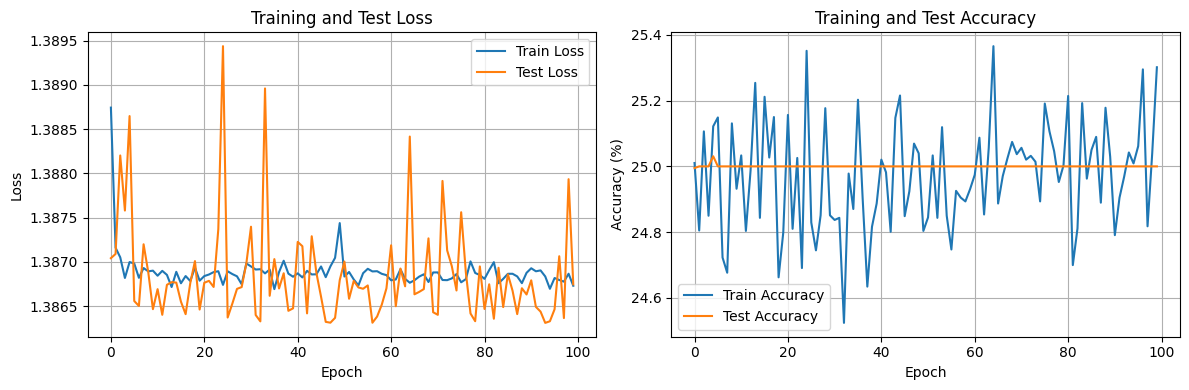

Model saved successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001):
    """
    Train the neural network
    """
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training history
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training"):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        # Testing phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for batch_features, batch_labels in test_loader:
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += batch_labels.size(0)
                test_correct += (predicted == batch_labels).sum().item()

        # Calculate metrics
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_accuracy = 100 * train_correct / train_total
        test_accuracy = 100 * test_correct / test_total

        # Store history
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
            print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
            print('-' * 50)

    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

def plot_training_history(history):
    """
    Plot training history
    """
    # Ensure the directory exists
    os.makedirs('results/plots', exist_ok=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot losses
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['test_accuracies'], label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('results/plots/training_history.png')
    plt.show()

if __name__ == "__main__":
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y, label_encoder, scaler = load_and_preprocess_data('data/combined_eeg_data.csv')

    # Create data loaders
    train_loader, test_loader = create_data_loaders(X, y, batch_size=64)

    # Initialize model
    model = EEGClassifier(input_size=64, num_classes=4)

    # Train model
    print("Starting training...")
    history = train_model(model, train_loader, test_loader, num_epochs=100)

    # Plot results
    plot_training_history(history)

    # Save model
    torch.save(model.state_dict(), 'models/saved_models/eeg_classifier.pth')
    print("Model saved successfully!")